<a href="https://colab.research.google.com/github/vishalpandeyshiv/seismic-facies-identification-starter-kit/blob/master/Time_to_Depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, seismic time data is to be converted into depth data and synthetic seismogram will be generated using sonic and density well logs. To recognize formation tops on seismic profiles (horizons), we mainly rely on well data. Well data includes petrophysical well logs and geological interpretation such as key formation boundries. Tying well data on seismic data is more percise if we generate synthetic seismogram.

Some steps are required to generate seismogram:
1- Data Preparation (Unit conversion and Sonic / Density Logs processing)
2- Time-Depth relationship construction
3- Acoustic Impedance(AI or Z) Calculation, AI (product of sonic wave velocity and medium density)
4- Reflection Coefficient(Rc) calculation
5- Resampling to the time domain and Rc recalculation
6- Wavelet & Convolution
7- Visualization

1- Data Prepration

We will implemet some data operation (like smoothing/despiking) using welly library developed by agile geoscience team.


In [ ]:
pip install lasio

In [ ]:
pip install welly

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
  Created wheel for welly: filename=welly-0.4.9-cp37-none-any.whl size=55559 sha256=dc6d65ac0ad250be26446708565d6faf5245871fd01f2310d693e964aea18bf8
  Stored in directory: /root/.cache/pip/wheels/1d/8c/d2/6d4acd157d22653d469ddc3c92336e7810e29522d37b93d500
  Created wheel for striplog: filename=striplog-0.8.8-cp37-none-any.whl size=83655 sha256=b085cb8996acdc0b2706ecfdafc16053c8cbe1d869b274d2e06682ea9a5a5280
  Stored in directory: /root/.cache/pip/wheels/f2/24/74/bd0c5947a61b8891bf41a3c7e7e3de470382315c1fae297402
Successfully built welly striplog


In [ ]:
import pandas as pd
import lasio
import numpy as np

# New Section

In [ ]:
import welly
from welly import Well

In [ ]:
w = Well.from_las('/1050383876.las')
# w.header                      # runing with welly lib we are not able to see las header data
w_las= lasio.read(r'/1050383876.las') # lasio lib will help
w_las.header

/usr/local/lib/python3.7/dist-packages/welly/well.py:193: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)
/usr/local/lib/python3.7/dist-packages/welly/curve.py:216: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)


{'Curves': [CurveItem(mnemonic="DEPT", unit="m", value="", descr="DEPTH", original_mnemonic="DEPT", data.shape=(19405,)),
  CurveItem(mnemonic="DT", unit="us/ft", value="", descr="DT", original_mnemonic="DT", data.shape=(19405,)),
  CurveItem(mnemonic="RHOB", unit="g/cm3", value="", descr="RHOB", original_mnemonic="RHOB", data.shape=(19405,)),
  CurveItem(mnemonic="SW", unit="m3/m3", value="", descr="SW", original_mnemonic="SW", data.shape=(19405,)),
  CurveItem(mnemonic="PHIE", unit="m3/m3", value="", descr="PHIE", original_mnemonic="PHIE", data.shape=(19405,))],
 'Other': '',
 'Parameter': [],
 'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS LOG ASCII STAN...),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="SINGLE LINE PER DEPT...),
  HeaderItem(mnemonic="CREA", unit="", value="8/24/2012 12:51", descr="22")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="1517.0", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="3850.70

Unit Conversion

To calculate Acoustic Impedance, we need to have Sonic log (DT) in µs/m unit as well as density log (RHOB) in kg/m3. Looking at header: DT has us/ft unit and RHOB g/cm3.


In [ ]:
w.data['DT'] = w.data['DT'] / 0.3048   #unit convert to µs/m
w.data['RHOB'] = w.data['RHOB'] * 1000  #unit convert to kg/m3

Despiking & Smoothing

Spikes are common on well logs, especially on sonic measurements. These spikes are not the true representative of rock properties variation through the well intervals and need to be eliminated.


In [ ]:


#Despiking
#Sonic Despiking
dt = w.data['DT']
w.data['DT_DS'] = dt.despike(window_length=50, z=2)

#Density Despiking
den = w.data['RHOB']
w.data['RHOB_DS'] = den.despike(window_length=50, z=2)



In [ ]:
#Smoothing 
#Sonic Smoothing
dt_ds = w.data['DT_DS']
w.data['DT_DS_SM'] = dt_ds.smooth(window_length=10, samples=False)
 
#Density Smoothing
den_ds = w.data['RHOB_DS']
w.data['RHOB_DS_SM'] = den_ds.smooth(window_length=10, samples=False)

2- Time-Depth relationship

Seismic data is measured in the time domain while well data mainly have depth domain. To convert time to depth and vice versa, we need to establish a relationship. There are several ways to do this but here, as we use the sonic log, which is reciprocal of sound wave velocity. Mathematically if we integrate DT over depth interval, we will compute the time-to-depth relationship. Before that, we should make a remedy for the upper part log data which has a data gap from the surface. As this is on-shore field data, we do not have a water column. The replacement velocity for the section above log is almost 2600 m/s. Simply, dividing gapped interval thickness (log start depth subtracted from kb) by replacement velocity will give us the time.


In [ ]:
log_start = 1517               # Depth of logging starts(m) from header
kb = 15                        # Kelly Bushing elevation(m) from header

In [ ]:
gap_int = log_start - kb
repl_vel = 2632                # this is from VSP data knowledge (m/s)
log_start_time = 2.0 * gap_int / repl_vel        # 2 for twt

T-D Establishment

Let's implement integration. As depth sampling interval is 0.1524 meter, we need to calculate the time that takes for that thickness to travel with measured sonic data. Then calculate cumulative travel time to downward. Calculating from log starting depth shows zero for first value while we know zero time belongs to ground surface. So, the travel time of this gap should be added to integrated sonic time.


In [ ]:
#first replace NaN values with zero
dt_iterval = np.nan_to_num(dt) * 0.1524 / 1e6
t_cum =  np.cumsum(dt_iterval) * 2
w.data['TWT'] = t_cum + log_start_time


In [ ]:
df = w.df()
print(df)

                   DT         RHOB   SW  ...    DT_DS_SM   RHOB_DS_SM       TWT
Depth                                    ...                                   
1517.0000  185.978669  1334.599972  NaN  ...  231.538315  1642.518456  1.141394
1517.1524  185.389769  1233.000040  NaN  ...  235.005109  1651.015497  1.141451
1517.3048  186.378286  1190.000057  NaN  ...  238.492810  1663.155496  1.141507
1517.4572  194.571525  1218.099952  NaN  ...  241.991691  1680.152419  1.141567
1517.6096  179.794291  1386.100054  NaN  ...  245.149686  1697.703188  1.141621
...               ...          ...  ...  ...         ...          ...       ...
4473.4076  214.616145  2506.000042  1.0  ...  191.324216  2620.296911  2.506421
4473.5600  211.386493  2539.299965  1.0  ...  191.744885  2618.433835  2.506486
4473.7124  206.549875  2579.699993  1.0  ...  192.192699  2616.635374  2.506549
4473.8648  200.235237  2618.099928  1.0  ...  192.645308  2615.101528  2.506610
4474.0172  193.026898  2639.400005  1.0 

3- Acoustic Impedance

Acoustic Impedance(AI, sometimes showed by Z) is defined as the product of sonic wave velocity and medium density. In reflection seismology, AI variation between geological layers is responsible for the energy reflection toward the surface where we collect seismic data.


In [ ]:
# Sonic velocity calculate
df['Vsonic'] = 1e6/df.DT_DS_SM                    #(unit: m/s)
print(df)

                   DT         RHOB   SW  ...   RHOB_DS_SM       TWT       Vsonic
Depth                                    ...                                    
1517.0000  185.978669  1334.599972  NaN  ...  1642.518456  1.141394  4318.939620
1517.1524  185.389769  1233.000040  NaN  ...  1651.015497  1.141451  4255.226643
1517.3048  186.378286  1190.000057  NaN  ...  1663.155496  1.141507  4192.998531
1517.4572  194.571525  1218.099952  NaN  ...  1680.152419  1.141567  4132.373295
1517.6096  179.794291  1386.100054  NaN  ...  1697.703188  1.141621  4079.140449
...               ...          ...  ...  ...          ...       ...          ...
4473.4076  214.616145  2506.000042  1.0  ...  2620.296911  2.506421  5226.729911
4473.5600  211.386493  2539.299965  1.0  ...  2618.433835  2.506486  5215.262987
4473.7124  206.549875  2579.699993  1.0  ...  2616.635374  2.506549  5203.111280
4473.8648  200.235237  2618.099928  1.0  ...  2615.101528  2.506610  5190.886859
4474.0172  193.026898  2639.

In [ ]:
# AI calculate
df['AI'] = df['Vsonic'] * df['RHOB_DS_SM']        #(unit: kg/m2.s)

4- Reflection Coefficient

Reflection Coefficient (Rc) is defined as impedance differences of two adjacent layers divided by their sum. Mathematically, this is derivative with respect to depth.


In [ ]:
Imp = df['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

# to adjust vector size copy the last element to the tail
Rc.append(Rc[-1])

In [ ]:
# Let's add Rc into dataframe as new column
df['Rc'] = pd.Series(Rc, index=df.index)

5- Resampling to the time domain and Rc calculation

Although we established a time-depth relationship(TDR), the components that we need for synthetic seismogram are in depth domain. Reflectivity series should be transferred into time domain for convolution. After defining the time vector, we can use the interpolation function from the numpy library.


In [ ]:
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time vector
t = np.arange(0, t_max, dt)
AI_tdom = np.interp(x=t, xp = df.TWT, fp = df.AI)    #resampling

After resampling, if we check AI vector size, it will be definitley diffrent from original one


In [ ]:


# again Rc calulation but in reampled time domain
Rc_tdom = []
for i in range(len(AI_tdom)-1):
    Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))
# to adjust vector size copy the last element to the tail
Rc_tdom.append(Rc_tdom[-1])



6- Wavelet & Convolution

In reflection seismology, it is assumed that the seismic data we record on the surface is the reflection of energy (due to rock property variation in depth) which is convolved (masked) with wavelet. From various wavelets, Ricker is one of the most common type as it is zero phase and favorable for seismic interpretation tasks.


In [ ]:
# define function of ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y


Convolution

In this step, we will convolve the reflectivity series with a wavelet to create a synthetic seismogram. It is commonly known as flip and slide a function over the other one.

In [ ]:
f=20            #wavelet frequency
length=0.512    #Wavelet vector length
dt=dt           # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) # ricker wavelet 
synthetic = np.convolve(w, Rc_tdom, mode='same')

7- Visualization
Formation tops

Well tops are one of the most import ingridinets for seismic interpretation. Let's read from csv file into dataframe and convert it to dictionary.


In [ ]:
df_top = pd.read_csv('/tops.csv') # read from csv file into dataframe
tops_dept = dict(df_top.values.tolist())  # convert to dictionary

To find out the corrosponding time value of tops in depth dictionary, we can either use velocity function to convert depth to time by very small error or find out the nearest value to the MD. We prefer the nearest value for tops in depth interval for simplicity. First, define a function to be able to iterate over the depth values. 'argmin' function is used to find out the values with the smallest duffrence from our intended value.


In [ ]:
def nearest_value(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [ ]:
TWT=df.TWT.values
tops_twt={}
for key, val in tops_dept.items():
    tops_twt[key]=TWT[nearest_value(df.index, val)]

Figure 1

In this figure, we will plot the well logs (overlaid with smooting and despiking results) and calculated AI and Reflectivity in depth domain.


In [ ]:
import matplotlib.pyplot as plt

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


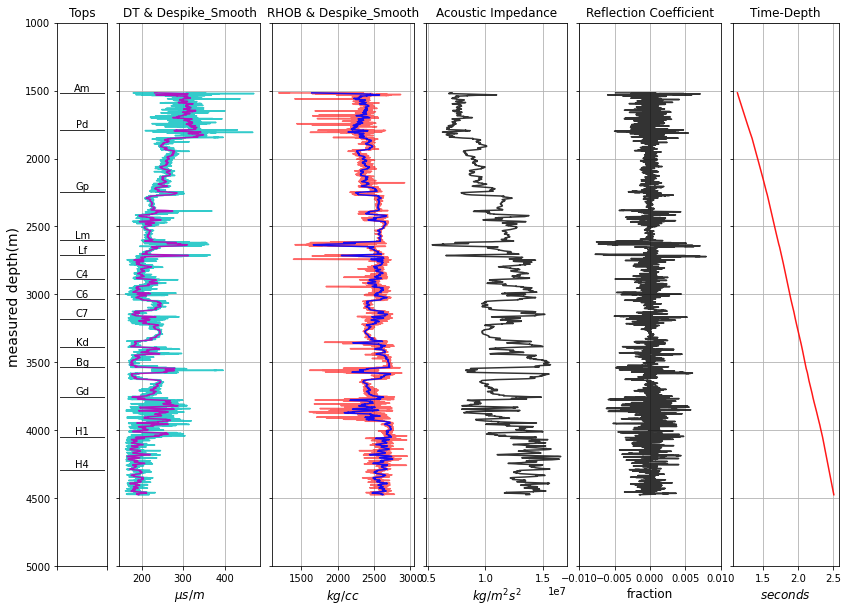

In [ ]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (14,10), gridspec_kw={'width_ratios': [0.7,2,2,2,2,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('measured depth(m) ', fontsize = '14' )
axs[0].set_xticklabels('')
for Top in tops_dept.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, MD in tops_dept.items():
    axs[0].text( x = 0.5,  y = float(MD), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( df.DT, df.index,'c', alpha=0.8)
axs[1].plot( df.DT_DS_SM, df.index,'m', alpha=0.9)
axs[1].set_title('DT & Despike_Smooth', style = 'normal')
axs[1].set_xlabel( r'$\mu s/m $', fontsize = '12')
axs[1].set_ylim(1000, 5000)
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( df.RHOB, df.index,'r', alpha=0.6)
axs[2].plot( df.RHOB_DS_SM, df.index,'b', alpha=0.9)
axs[2].set_title('RHOB & Despike_Smooth', style = 'normal')
axs[2].set_xlabel('$kg/cc$', fontsize = '12')
axs[2].set_ylim(1000, 5000)
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------  
axs[3].plot( df.AI, df.index,'k', alpha=0.8)
axs[3].set_title('Acoustic Impedance', style = 'normal')
axs[3].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
axs[3].set_ylim(1000, 5000)
axs[3].invert_yaxis()
axs[3].grid()
# -----------------------------------------------------------------------------------track5-----------
axs[4].plot( df.Rc, df.index,'k', alpha=0.8)
axs[4].set_title('Reflection Coefficient', style = 'normal')
axs[4].set_xlabel('fraction' , fontsize = '12')
axs[4].set_ylim(1000, 5000)
axs[4].set_xlim(-0.01, 0.01)
axs[4].invert_yaxis()
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
axs[5].plot( df.TWT, df.index,'r', alpha=0.9)
axs[5].set_title('Time-Depth', style = 'normal')
axs[5].set_xlabel( '$seconds$', fontsize = '12')
axs[5].set_ylim(1000, 5000)
axs[5].invert_yaxis()
# axs[5].set_yticklabels('')
axs[5].grid()
plt.savefig('Fig1.png', dpi=300)

Figure 2

In this figure, we will plot AI and colvolution results in time domain. We also have an access to real surface seismic tracess around a well that can juxtapose with synthetic seismogram to see how match with that data.


In [ ]:
df_offset_seis= pd.read_csv('/around_well_seismic.csv', skiprows=lambda x: x % 2)

       time  cdp409  cdp410  cdp412  cdp413
0     0.000       0       0       0       0
1     0.004       0       0       0       0
2     0.008       0       0       0       0
3     0.012       0       0       0       0
4     0.016       0       0       0       0
...     ...     ...     ...     ...     ...
1371  5.484    2520     845    3835    3772
1372  5.488   13512   15714   18454   18894
1373  5.492   19757   21341   22921   23256
1374  5.496   20333   20500   20598   20658
1375  5.500   14600   13319   10355    8030

[1376 rows x 5 columns]


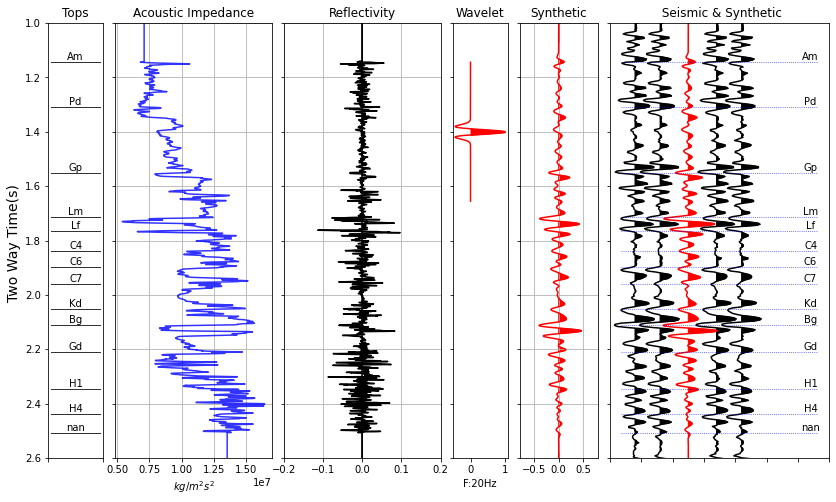

In [ ]:
fig, axs = plt.subplots(1, 6, sharey=False, figsize = (14,8), gridspec_kw={'width_ratios': [0.7,2,2,0.7,1,2.8]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('Two Way Time(s) ', fontsize = '14' )
axs[0].set_xticklabels('')
axs[0].set_ylim(1 , 2.6)
axs[0].invert_yaxis()

for Top in tops_twt.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[0].text( x = 0.5,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( AI_tdom, t,'b', alpha=0.8)
axs[1].set_title('Acoustic Impedance', style = 'normal')
axs[1].set_xlabel( r'$kg/m^2s^2$', fontsize = '10')
axs[1].set_ylim(1 , 2.6)
axs[1].set_yticklabels('')
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( Rc_tdom, t,'k')
axs[2].plot([0, 0], [t.min(), t.max()], '-', c='k')
axs[2].set_title('Reflectivity', style = 'normal')
axs[2].set_ylim(1 , 2.6)
axs[2].set_xlim(-0.2 , 0.2)
axs[2].set_yticklabels('')
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------   
axs[3].plot( w, t0+1.4,'r', alpha=0.99)
axs[3].fill_betweenx(t0+1.4 , w,  0,  w > 0.0,  color='r')
axs[3].set_title('Wavelet', style = 'normal')
axs[3].set_xlabel('F:'+ str(f)+'Hz' , fontsize = '10')
axs[3].set_yticklabels('')
axs[3].set_ylim(1 , 2.6)
axs[3].invert_yaxis()
# -----------------------------------------------------------------------------------track5------------
axs[4].plot( synthetic, t ,'r')
axs[4].fill_betweenx(t, synthetic,  0,  synthetic > 0,  color='r')
axs[4].set_title('Synthetic', style = 'normal')
axs[4].set_ylim(1 , 2.6)
axs[4].set_xlim(-0.8 , 0.8)
axs[4].invert_yaxis()
axs[4].set_yticklabels('')
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
offsets=[0.4, 0.8 , 1.25, 1.7, 2.1]

x1= (df_offset_seis.cdp409.values/1e5) + offsets[0]
x2= (df_offset_seis.cdp410.values/1e5) + offsets[1]
x3= (df_offset_seis.cdp412.values/1e5) + offsets[3]
x4= (df_offset_seis.cdp413.values/1e5) + offsets[4]
t_sei=df_offset_seis.time

axs[5].plot( x1, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[0] , x1, where=(x1>offsets[0]),color='k')
axs[5].plot( x2, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[1] , x2, where=(x2>offsets[1]),color='k')
axs[5].plot( synthetic+offsets[2], t ,'r')
axs[5].fill_betweenx(t, offsets[2] , (synthetic+offsets[2]),
                     where=((synthetic+offsets[2])>offsets[2]),color='r')
axs[5].plot( x3, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[3] , x3, where=(x3>offsets[3]),color='k')
axs[5].plot( x4, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[4] , x4, where=(x4>offsets[4]),color='k')

axs[5].set_title(' Seismic & Synthetic', style = 'normal')
axs[5].set_yticklabels('')
axs[5].set_xticklabels('')
axs[5].set_ylim(1 , 2.6)
axs[5].set_xlim(0 , 03.5)
axs[5].invert_yaxis()
for Top in tops_twt.values() :
    axs[5].axhline( y = float(Top), color = 'b', lw = 0.8, ls = ':', 
                   alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[5].text( x = 3.2,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')    

plt.savefig('Fig2.png', dpi=600)
print(df_offset_seis)

In [ ]:
print(df)

                   DT         RHOB   SW  ...       Vsonic            AI        Rc
Depth                                    ...                                     
1517.0000  185.978669  1334.599972  NaN  ...  4318.939620  7.093938e+06 -0.004851
1517.1524  185.389769  1233.000040  NaN  ...  4255.226643  7.025445e+06 -0.003703
1517.3048  186.378286  1190.000057  NaN  ...  4192.998531  6.973609e+06 -0.002198
1517.4572  194.571525  1218.099952  NaN  ...  4132.373295  6.943017e+06 -0.001287
1517.6096  179.794291  1386.100054  NaN  ...  4079.140449  6.925170e+06 -0.000138
...               ...          ...  ...  ...          ...           ...       ...
4473.4076  214.616145  2506.000042  1.0  ...  5226.729911  1.369558e+07 -0.001454
4473.5600  211.386493  2539.299965  1.0  ...  5215.262987  1.365582e+07 -0.001510
4473.7124  206.549875  2579.699993  1.0  ...  5203.111280  1.361465e+07 -0.001469
4473.8648  200.235237  2618.099928  1.0  ...  5190.886859  1.357470e+07 -0.001346
4474.0172  193.0

In [ ]:
seist = df_offset_seis['time']
seist = seist.to_list()
seist = seist[250:651]
print(seist)
output = [0] * len(seist)
for i in range(len(seist)-1):
  output[(i)] = seist[(i+1)] - seist[(i)]
print(output)
seisv = df['Vsonic']
seisv = seisv.to_list()
print(seisv)
print(len(seist))
print(len(seisv))

[1.0, 1.004, 1.008, 1.012, 1.016, 1.02, 1.024, 1.028, 1.032, 1.036, 1.04, 1.044, 1.048, 1.052, 1.056, 1.06, 1.064, 1.068, 1.072, 1.0759999999999998, 1.08, 1.084, 1.088, 1.092, 1.0959999999999999, 1.1, 1.104, 1.1079999999999999, 1.112, 1.1159999999999999, 1.12, 1.124, 1.128, 1.1320000000000001, 1.136, 1.14, 1.1440000000000001, 1.148, 1.1520000000000001, 1.156, 1.16, 1.1640000000000001, 1.168, 1.172, 1.176, 1.18, 1.1840000000000002, 1.188, 1.192, 1.196, 1.2, 1.204, 1.208, 1.212, 1.216, 1.22, 1.224, 1.228, 1.232, 1.236, 1.24, 1.244, 1.248, 1.252, 1.256, 1.26, 1.264, 1.268, 1.272, 1.276, 1.28, 1.284, 1.288, 1.2919999999999998, 1.296, 1.3, 1.304, 1.308, 1.3119999999999998, 1.3159999999999998, 1.32, 1.324, 1.328, 1.3319999999999999, 1.3359999999999999, 1.34, 1.344, 1.348, 1.3519999999999999, 1.3559999999999999, 1.36, 1.364, 1.368, 1.3719999999999999, 1.376, 1.38, 1.3840000000000001, 1.3880000000000001, 1.392, 1.396, 1.4, 1.4040000000000001, 1.4080000000000001, 1.412, 1.416, 1.42, 1.424000000

Refrences:

Agile geoscience and SEG WiKI.
